In [1]:
import numpy as np
import rasterio as rio
from rasterio import fill
import skimage as ski
import matplotlib.pyplot as plt
import glob
import os
from rasterio.plot import reshape_as_raster, reshape_as_image
import json
import scipy.stats as stats
import statsmodels.formula.api
from sklearn.cluster import KMeans
from math import ceil
from skimage.draw import line
from skimage.morphology import dilation
import skimage.io as skio
os.chdir("/home/rave/tana-crunch/waves/cloud-free-planet/atsa-python")
import pyatsa_configs
from skimage.morphology import flood_fill
from multiprocessing.dummy import Pool as ThreadPool
from multiprocessing import Pool, cpu_count

###porting code from original idl written by Xiaolin Zhu
ATSA_DIR="/home/rave/tana-crunch/waves/cloud-free-planet/atsa-test-unzipped/"
img_path = os.path.join(ATSA_DIR, "planet-pyatsa-test/stacked_larger_utm.tif")
angles_path = os.path.join(ATSA_DIR, "planet-pyatsa-test/angles_larger_utm.txt")
configs = pyatsa_configs.ATSA_Configs(img_path, angles_path, ATSA_DIR)


def map_processes(func, args_list):
    """
    Set MAX_PROCESSES in preprocess_config.yaml
    args_sequence is a list of lists of args
    """
    processes = cpu_count()
    pool = Pool(processes)
    results = pool.starmap(func, args_list)
    pool.close()
    pool.join()
    return results

#Computing the Clear Sky Line for Planet Images in T Series
#Zhu set to 1.5 if it was less than 1.5 but this might not be a good idea for Planet 
#due to poorer calibration?
def reject_outliers_by_med(data, m = 2.):
    """
    Reject outliers based on median deviation
    https://stackoverflow.com/questions/11686720/is-there-a-numpy-builtin-to-reject-outliers-from-a-list
    """
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m].flatten()

def reject_outliers_by_mean(data_red, data_blue, m = 3.):
    """
    Reject outliers based on deviation from mean
    This is the method used in Zhu and Elmer 2018
    """
    return (data_red[data_red <= np.mean(data_red) + m * np.std(data_red)], \
            data_blue[data_red <= np.mean(data_red) + m * np.std(data_red)])

def get_histo_labels(img, rmin0, rmax, nbins=50):
    """
    Takes an image of shape [H, W, Channel], gets blue and red bands,
    and computes histogram for blue values. then it finds the array indices
    for each bin of the histogram.
    
    Args:
        img (numpy array): the input image, part of a time series of images
        rmin0 (int): minimum edge of the histogram (later adjusted based on each image)
        rmax (int): maximum edge of the histogram
        nbins (int): number of histogram bins
        
    Returns:
        the array of histogram indices of same shape as a band or (nan, nan)
        which is later passed to compute hot when nanmean is called.
    
    """
    # make 3D arrays for blue and red bands to compute clear sky lines
    blue = img[:,:,0]
    red = img[:,:,2]
    # finding samples, there should be at least 500 values to 
    # compute clear sky line
    good_histo_values = np.where((blue<rmax)&(blue>rmin0), blue, 0)
    if np.count_nonzero(good_histo_values) > 500:
        rmin = np.min(good_histo_values[good_histo_values!=0]) # starts binning where we have good data
        # computes the histogram for a single blue image
        (means, edges, numbers)=stats.binned_statistic(blue.flatten(), 
                blue.flatten(), statistic='mean', 
                bins=50, range=(int(rmin),int(rmax)))
        
        histo_labels_reshaped = np.reshape(numbers, (blue.shape[0],blue.shape[1]))
        return histo_labels_reshaped
    
    else:
        # we return None here to signal that we need to use the 
        # mean slope and intercept for the good clear skylines
        return np.ones(blue.shape)*np.nan
    
def get_bin_means(img, histo_labels_reshaped, n=20):
    """
    Takes the same img as get_histo_labels and the histogram index array. 
    Only computes means for bins with at least n values and only takes the
    highest n values in each bin to compute the mean. n is hardcoded to 20
    in Zhu code.
    
    Args:
        img (numpy array): the input image, part of a time series of images
        histo_labels_reshaped: array of same shape as the img bands
        
    Returns:
        a tuple of two lists, the blue means and the read means
    """
    blue = img[:,:,0]
    red = img[:,:,2]

    red_means=[]
    blue_means=[]
    # removing last element because for some reason there was an extra bin in the python version compared to idl
    for i in np.unique(histo_labels_reshaped)[0:-1]:

        red_vals = red[histo_labels_reshaped==i]
        blue_vals = blue[histo_labels_reshaped==i]
        # Zhu set this thresh for number of values needed in bin to compute mean
        if len(blue_vals) >= n: 
            # before selecting top 20, reject outliers based on 
            # red values and pair with corresponding blue values as per Zhu code
            (red_vals_no_outliers, blue_vals_no_outliers) = reject_outliers_by_mean(red_vals, blue_vals)

            ## added these steps from Zhu code, but not sure if/why they are necessary
            # they result in fewer values being averaged in each bin sometimes
            # need to sort by red and use same sorting for blue to keep pairs together
            sort_indices = np.argsort(red_vals_no_outliers)
            red_vals_sorted = red_vals_no_outliers[sort_indices]
            blue_vals_sorted = blue_vals_no_outliers[sort_indices]
            select_n = min([n, ceil(.01*len(blue_vals))])
            red_selected = red_vals_sorted[-select_n:]
            blue_selected = blue_vals_sorted[-select_n:]
            ##
            #finds the highest red values and takes mean
            red_means.append(
                np.mean(
                    red_selected
                )
            )
            blue_means.append(
                np.mean(
                    blue_selected
                )
            )
    return (blue_means, red_means)
    
    
def get_intercept_and_slope(blue_means, red_means, histo_labels_reshaped, nbins):
    """
    Takes the mean lists, the histogram labels, and nbins and computes the intercept
    and slope. includes logic for dealing with too few bins and if the slope that
    is computed is too low.
    
    Args:
        blue_means (list): means of the bins for the blue band
        red_means (list): means of the bins for the red band
        histo_labels_reshaped: array of same shape as the img bands
        
    Returns:
        a tuple of two floats, the intercept and the slope.
    """
    # we want at least half of our ideal data points to construct the clear sky line
    if len(np.unique(histo_labels_reshaped)) > .5 * nbins:
        #followed structure of this example: https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html
        model = statsmodels.formula.api.quantreg('reds~blues', {'reds':red_means, 'blues':blue_means})

        result = model.fit()

        intercept = result.params[0]
        slope = result.params[1]
        # mark as mean, later this is filled with mean slope and mean intercept
        if slope < 1.5:
            return (np.nan,np.nan)
        return (intercept, slope)
    # if we don't have even half the ideal amount of bin means...
    # mark as mean, later this is filled with mean slope and mean intercept
    else: 
        return (np.nan, np.nan)
    
def get_clear_skyline(img, rmin0, rmax, nbins=50):
    """
    Computes the clear sky line for a single image using the
    automatic bin based approach used by Zhen and Elmer 2018.
    Returns the slope and intercept of the clear sky line.
    Larger images are easier to compute a clear sky line, 
    smaller images with more clouds are more difficult and may
    need to take an assumed slope or both slope and intercept.
    This function puts the steps together. 
    
    Args:
        img (numpy array): bgrnir array
        rmin0 (int): minimum edge of the histogram (later adjusted based on each image)
        rmax (int): maximum edge of the histogram
        nbins (int): number of histogram bins
    
    Returns:
        tuple of nan if there are not enough good values to compute 
        a histogram
        
        or
        
        a tuple with the intercept and slope of the clear sky line.
        See get_intercept_and_slope for logic on how intercept and slope
        is computed with different edge cases
    """

    histo_labels_reshaped = get_histo_labels(img, rmin0, rmax, nbins)
    if np.isnan(histo_labels_reshaped).all() == True:
        return (np.nan, np.nan)
    
    blue_means, red_means = get_bin_means(img, histo_labels_reshaped)
    
    intercept, slope = get_intercept_and_slope(blue_means, red_means, histo_labels_reshaped, nbins)
    
    return (intercept, slope)
    
def compute_hot_series(t_series, rmin, rmax, n_bin=50):
    """Haze Optimized Transformation (HOT) test
    Equation 3 (Zhu and Woodcock, 2012)
    Based on the premise that the visible bands for most land surfaces
    are highly correlated, but the spectral response to haze and thin cloud
    is different between the blue and red wavelengths.
    Zhang et al. (2002)
    In this implementation, the slope (a) and intercept(b)
    of the clear sky line are computed automatically using a bin based approach.

    Parameters
    ----------
    t_series: a 4D array with the band index as the third axis, image index as
    the fourth axis (counting from 1st).

    Output
    ------
    ndarray: The values of the HOT index for the image, a 3D array
    """
    blues = t_series[:,:,0,:]
    reds = t_series[:,:, 2,:]
    intercepts_slopes = np.array(
        list(map(lambda x: get_clear_skyline(x,rmin,rmax),
                np.moveaxis(t_series,3,0)))
        )
    # assigns slope and intercept if an image is too cloudy (doesn't have 500 pixels in rmin, rmax range)
    if np.isnan(intercepts_slopes).all():
        # extreme case where no images can get a clear sky line
        intercepts_slopes[:,1] = 1.5
        intercepts_slopes[:,0] = 0
    if np.isnan(intercepts_slopes).any():
        # case where some images can't get a clear skyline
        intercepts_slopes[:,1][np.isnan(intercepts_slopes[:,1])] = np.nanmean(intercepts_slopes[:,1])
        intercepts_slopes[:,0][np.isnan(intercepts_slopes[:,0])] = np.nanmean(intercepts_slopes[:,0])
    def helper(blue, red, ba):
        b,a = ba
        return abs(blue*a - red+b)/np.sqrt(1.0+a**2)
    # map uses the first axis as the axis to step along
    # need to use lambda to use multiple args
    hot_t_series = np.array(list(map(lambda x,y,z: helper(x,y,z), 
                    np.moveaxis(blues,2,0), 
                    np.moveaxis(reds,2,0), 
                    intercepts_slopes)))
    return hot_t_series, intercepts_slopes

def reassign_labels(class_img, cluster_centers, k=3):
    """Reassigns mask labels of t series
    based on magnitude of the cluster centers.
    This assumes land will always be less than thin
    cloud which will always be less than thick cloud,
    in HOT units"""
    idx = np.argsort(cluster_centers.sum(axis=1))
    lut = np.zeros_like(idx)
    lut[idx] = np.arange(k)
    return lut[class_img]

def sample_and_kmeans(hot_t_series, hard_hot=6000, sample_size=10000):
    """Trains a kmeans model on a sample of the time series
    and runs prediction on the time series.
    A hard coded threshold for the hot index, hard_hot, is
    for allowing the kmeans model to capture more variation 
    throughout the time series. Without it, kmeans is skewed toward
    extremely high HOT values and classifies most of the time series
    as not cloudy."""
    # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    # kmeans centers differ slightly due to the method of initialization.
    # Zhu used mean and standard deviation fo the systematic sample, we use kmeans++
    km = KMeans(n_clusters=3, n_init=1, max_iter=50, tol=1e-4, n_jobs=-1, 
                      verbose=False, random_state=4)

#     sample_values = np.random.choice(
#         hot_t_series.flatten()[hot_t_series.flatten()<hard_hot], 
#         size=sample_size).reshape(-1,1)
    interval = int(len(hot_t_series.flatten())/sample_size)
    sample_values = hot_t_series.flatten()[::interval].reshape(-1,1)
    
    fit_result = km.fit(sample_values)
    
    predicted_series = fit_result.predict(hot_t_series.flatten().reshape(-1,1)).reshape(hot_t_series.shape)
    
    return reassign_labels(predicted_series, fit_result.cluster_centers_, k=3), fit_result.cluster_centers_

def calculate_upper_thresh(hot_t_series, cloud_masks, A_cloud):
    """Uses temporal refinement as defined by Zhu and Elmer 2018
    to catch thin clouds by defining the upper boundary, U for clear 
    pixels. Later we might want to compute a neighborhood std 
    through the t_series."""
    hot_potential_clear = np.array(list(map(
        lambda x, y: np.where(x>0, np.nan, y),
        cloud_masks, hot_t_series))) # set cloud to nan
    hot_potential_cloudy = np.array(list(map(
        lambda x, y: np.where(x==0, np.nan, y),
        cloud_masks, hot_t_series))) # set non cloud to nan
    t_series_std = np.nanstd(hot_potential_clear, axis=0)
    t_series_mean = np.nanmean(hot_potential_clear, axis=0)
    t_series_min = np.nanmin(hot_potential_clear, axis=0)
    t_series_max = np.nanmax(hot_potential_clear, axis=0)
    range_arr = t_series_max - t_series_min
    
    # cloud_series_min can be computed more efficiently using k means centers 
    # if a single k means model is used
    # according to Zhu in personal communciation. This is done in IDL code
    
    # NRDI (adjust_T in the IDL code) is a problem here because the HOT indices 
    # vary a lot in the planet images. if we train a kmeans model for each image
    # Th_initial will have a very low initial value, if we train one kmeans model
    # then the model will produce innacurate initial masks because of extremely high
    # HOT values. Need to find a work around.
    
    # the sticky point is how cloud_series_min is calculated. if it is the minimum
    # of all cloudy areas calculated by multiple kmeans models, it is not correct for 
    # the whole t series
    
    cloud_series_min = np.nanmin(hot_potential_cloudy.flatten(), axis=0)
    
    NRDI = (cloud_series_min - range_arr)/(cloud_series_min + range_arr)
    upper_thresh_arr = t_series_mean + (A_cloud+NRDI)*t_series_std
    
    return (upper_thresh_arr, hot_potential_clear, hot_potential_cloudy)

def apply_upper_thresh(t_series, hot_t_series, upper_thresh_arr, initial_kmeans_clouds, hot_potential_clear, hot_potential_cloudy, dn_max):
    """Applies the masking logic to refine the initial cloud
    masks from k-means using the global threshold and 
    upper threshold computed from the time series.
    Returns a time series of refined masks where 2 is cloud and 1 is clear land."""
    
    cloud_series_mean_global = np.nanmean(hot_potential_cloudy.flatten(), axis=0)
    cloud_series_std_global = np.nanstd(hot_potential_cloudy.flatten(), axis=0)
    global_cloud_thresh = cloud_series_mean_global - 1.0*cloud_series_std_global
    # 0 is where hot is below upper threshold, 1 is above
    #testing fix, misse dthat I need to use this thresh here to refine
    #initial clouds by setting pixels to not cloudy if the HOT values are too low
    #refine initial cloud
    initial_kmeans_clouds_binary = np.where(initial_kmeans_clouds > 0, 2 , 1)
    refined_masks = np.where(np.less(hot_potential_cloudy, upper_thresh_arr), 1, initial_kmeans_clouds_binary)
    # add missed clouds
    refined_masks = np.where(np.logical_and(np.greater(hot_potential_clear, upper_thresh_arr), reshape_as_raster(np.greater(t_series[:,:,2,:],dn_max*.1))), 2, refined_masks)
    
    global_thresh_arr = np.ones(refined_masks.shape)*global_cloud_thresh
    
    refined_masks = np.where(hot_t_series > global_cloud_thresh, 2, refined_masks)
    
    return refined_masks

def cloud_height_min_max(angles, longest_d, shortest_d):
    """Calculates the range of possible cloud heights using the 
    scene metadata. The longest distance between a shadow and cloud
    specified in the config cannot be larger than the number of rows 
    or columns in the image.
    
    Args:
        angles (numpy array): 1st column is sun elevation, 2nd is azimuth 
    """
    angles = angles/180.0*3.1415926
    h_high=longest_d/(((np.tan(angles[:,0])*np.sin(angles[:,1]))**2+(np.tan(angles[:,0])*np.cos(angles[:,1]))**2)**0.5)
    h_low=shortest_d/(((np.tan(angles[:,0])*np.sin(angles[:,1]))**2+(np.tan(angles[:,0])*np.cos(angles[:,1]))**2)**0.5)
    return h_high, h_low

def cloud_height_ranges(h_high, h_low):
    """
    Takes two arrays of the max cloud height and minimum cloud height, 
    returning a list of arrays the same length as the time series 
    containing the range of cloud heights used to compute the cloud shadow masks.
    
    Returns: Difference between heighest potential height and lowest, in pixel units.
    """
    h_range_lengths = np.ceil((h_high-h_low)/3.0)
    h_ranges = []
    for i,x in enumerate(h_range_lengths):
        h_ranges.append(np.arange(x)*3+h_low[i])
    return h_ranges

def shadow_shift_coords(h_ranges, angles):
    """
    Computes the possible minimum and maximum x and y magnitudes and 
    directions (in a cartesian sense) for shadows for each scene based 
    on the scene geometry with the sun. Used to determine the direction of the shadow.
    
    Args:
        h_ranges (list of numpy arrays): the ranges of cloud heights for 
            each scene, same length as time series
        angles (numpy array): the sun elevation and azimuth angles. 
            column 0 is sun elevation, 1 is azimuth
    Returns:
        The ending x and y direction and magnitude of the 
            potential shadow relative to the cloud mask
    """
    angles = angles/180.0*3.1415926
    end_x1s = []
    end_y1s = []
    for i, heights in enumerate(h_ranges):      
        end_x1s.append(int(round(-heights[-1]*np.tan(angles[i,0])*np.sin(angles[i,1]))))
        end_y1s.append(int(round(heights[-1]*np.tan(angles[i,0])*np.cos(angles[i,1]))))
    return list(zip(end_x1s, end_y1s))

def make_rectangular_struct(shift_coord_pair):
    """
    Makes the rectangular array with the line structure for dilation int he cloud shadow direction.
    Expects the ending x and y coordinate in array index format for the maximal cloud shadow at the
    maximal cloud height. Array index format means positive y indicates the shadow is south of the cloud, 
    positive x means the shadow is more east of the cloud. rr and cc are are intermediate arrays that store 
    the indices of the line. This line will run from the center of the struct to a corner of the array that 
    is opposite from the direction of the dilation.
    
    Args:
        shift_coord_pair (tuple): Contains the following
            shift_x (int): The maximum amount of pixels to shift the cloud mask in the x direction
            shift_y (int): The maximum amount of pixels to shift the cloud mask in the y direction
    Returns: The struct used by the skimage.morphology.dilation to get the potential shadow mask for a single
                image.
        
    """
    shift_x, shift_y = shift_coord_pair
    struct = np.zeros((abs(shift_y)*2+1, abs(shift_x)*2+1))
    
    if shift_x < 0 and shift_y < 0:
        rr, cc = line(int(abs(shift_y)),int(abs(shift_x)), abs(shift_y)*2, abs(shift_x)*2)  
    elif shift_x < 0 and shift_y > 0:
        rr, cc = line(int(abs(shift_y)),int(abs(shift_x)), 0, abs(shift_x)*2)
    elif shift_x > 0 and shift_y > 0:
        rr, cc = line(int(abs(shift_y)),int(abs(shift_x)), 0, 0)   
    elif shift_x > 0 and shift_y < 0:
        rr, cc = line(int(abs(shift_y)),int(abs(shift_x)), abs(shift_y)*2, 0)   
    struct[rr,cc] = 1
    # removes columns and rows with only zeros, doesn't seem to have an affect
    # struct = struct[~np.all(struct == 0, axis=1)]
    # struct = struct[:, ~np.all(struct == 0, axis=0)]
    return struct

def potential_shadow(struct, cloud_mask):
    """
    Makes the shadow mask from the struct and the cloud mask
    """
    d = dilation(cloud_mask==2, selem=struct)
    d = np.where(d==1, 0, 1)
    d = np.where(cloud_mask==2, 2, d)
    return d

def make_potential_shadow_masks(shift_coords, cloud_masks):
    structs = []
    
    for i in shift_coords:
        structs.append(make_rectangular_struct(i))
        
    shadow_masks = list(map(lambda x, y: potential_shadow(x,y), structs, cloud_masks))
    return np.stack(shadow_masks, axis=0), structs

def make_potential_shadow_masks_multi(shift_coords, cloud_masks):
    args_list = []
    
    for i,coord in enumerate(shift_coords):
        args_list.append((make_rectangular_struct(coord),cloud_masks[i]))
        
    shadow_masks = list(map_processes(potential_shadow, args_list))
    return np.stack(shadow_masks, axis=0)

In [2]:
import time
start = time.time()

angles = np.genfromtxt("../atsa-python/angles_larger_utm.txt", delimiter=' ')

hot_t_series, intercepts_slopes = compute_hot_series(configs.t_series, configs.rmin, configs.rmax)

initial_kmeans_clouds, kmeans_centers = sample_and_kmeans(hot_t_series, hard_hot=5000, sample_size=10000)

upper_thresh_arr, hot_potential_clear, hot_potential_cloudy = calculate_upper_thresh(hot_t_series, initial_kmeans_clouds, configs.A_cloud)

refined_masks = apply_upper_thresh(configs.t_series, hot_t_series, upper_thresh_arr, initial_kmeans_clouds, hot_potential_clear, hot_potential_cloudy, configs.dn_max)

from skimage.morphology import opening, dilation

# axis 0 must be the image count axis, not height or width
# refined_masks = np.apply_along_axis(opening, 0, refined_masks) # removes single pixel clouds

# refined_masks = np.apply_along_axis(lambda x: dilation(x, selem=np.ones(5,5)), 0, refined_masks)

for i in np.arange(refined_masks.shape[0]):
    refined_masks[i] = opening(refined_masks[i])
    refined_masks[i] = dilation(refined_masks[i], np.ones((5,5)))

print("seconds ", time.time()-start)
print("finished cloud masking")

start = time.time()

angles = np.genfromtxt("../atsa-python/angles_larger_utm.txt", delimiter=' ')
h_high, h_low = cloud_height_min_max(angles, configs.longest_d, configs.shortest_d)
h_ranges = cloud_height_ranges(h_high, h_low)
shift_coords = shadow_shift_coords(h_ranges, angles)
potential_shadow_masks = make_potential_shadow_masks_multi(shift_coords, refined_masks)

print("seconds ", time.time()-start)
print("finished potential shadow masking")

/home/rave/miniconda3/envs/geo/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:237: RuntimeWarning: invalid value encountered in less_equal
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/home/rave/miniconda3/envs/geo/lib/python3.6/site-packages/ipykernel/__main__.py:358: RuntimeWarning: invalid value encountered in less
/home/rave/miniconda3/envs/geo/lib/python3.6/site-packages/ipykernel/__main__.py:360: RuntimeWarning: invalid value encountered in greater


seconds  21.748252868652344
finished cloud masking
seconds  375.97195386886597
finished potential shadow masking


In [10]:
import scipy.io as io
state = io.readsav("/home/rave/tana-crunch/waves/cloud-free-planet/atsa-python/idl-shadow-variables.sav")

In [11]:
def min_cloud_nir(masks, t_series):
    """
    Gets the nir band of the scene with the minimum amount of cloud. 
    This will need to be reworked to handle partial scenes so that
    only full scenes are used.
    
    Args:
        masks (numpy array): a 3D array of masks of shape 
                        (count, height, width)
        t_series (numpy array): array of shape (height, width, bands, count) ordered RGBNIR
    Returns (tuple): the nir band of the scene with the least clouds and the index of this scene in the t series
    """
    assert np.unique(masks[0])[-1] == 2
    cloud_counts = [(i==2).sum() for i in masks]
    min_index = np.argmin(cloud_counts)
    return t_series[:,:,3,min_index], min_index  # 3 is NIR
clearest_land_nir, clearest_land_index = min_cloud_nir(potential_shadow_masks, configs.t_series)

In [12]:
def gain_and_bias(potential_shadow_masks, nir, clearest_land_nir, clearest_index, nir_index):
    """
    Calculates gain for a single imag ein the time series relative to the clearest land image
        Args:
            potential_shadow_masks (numpy array): masks of shape (count, height, width) where 0 is shadow, 1 is clear, 2 is cloud
            nir (numpy array): nir band of the scene to compute gain and bias for
            clearest_land_nir: nir band of the clearest scene
            clearest_index: index for clearest nir band, used for filtering with masks
            nir_index: index for the other nir band
        Returns (tuple): (gain, bias)
    """
    
    # index 3 is NIR, 1 in the mask is clear land
    both_clear = (potential_shadow_masks[clearest_index]==1) & (potential_shadow_masks[nir_index]==1)
    if both_clear.sum() > 100:
        clearest = clearest_land_nir[both_clear]
        nir = nir[both_clear]
        gain = np.std(clearest)/np.std(nir)
        bias  = np.mean(clearest) - np.mean(nir) * gain
    else:
        gain = 1
        bias = 0
    return gain, bias

def gains_and_biases(potential_shadow_masks, t_series, clear_land_nir, clear_land_index):
    gains_biases = []
    for i in np.arange(t_series.shape[-1]):
        gain, bias = gain_and_bias(potential_shadow_masks, t_series[:,:,3,i], clear_land_nir, clear_land_index, i)
        gains_biases.append((gain,bias))
    return gains_biases

gains_biases = gains_and_biases(potential_shadow_masks, configs.t_series, clearest_land_nir, clearest_land_index)

In [83]:
def shadow_index_land(potential_shadow_masks, t_series, gains_biases):
    """
    Applies gain and bias to get shadow index from nir for each scene in t series.
    
    Returns (numpy array): shape (count, height, width) of the nir band shadow index 
                where there was previously calculated to be potential shadow
    """
    shadow_inds = []
    for i in np.arange(t_series.shape[-1]):
        # applies calcualtion only where mask says there is not cloud 
        # might need to do this differently for water
        shadow_inds.append(np.where(potential_shadow_masks[i]!=2, t_series[:,:,3,i]*gains_biases[i][0]+gains_biases[i][1], 0))
        
    return np.stack(shadow_inds)

shadow_inds = shadow_index_land(potential_shadow_masks, configs.t_series, gains_biases)

### Testing shadow refinement with flood fill, no good python implementation for IDW

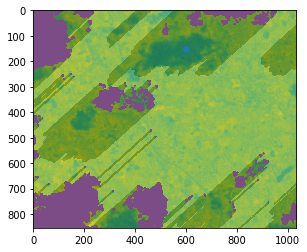

In [85]:
plt.imshow(shadow_inds[42])
plt.imshow(potential_shadow_masks[42], cmap='gray',alpha=.3)
plt.scatter([600], [150])

In [88]:
np.where(shadow_inds[42]==0,np.nan,shadow_inds[42])

array([[          nan,           nan,           nan, ..., 3554.44152672,
        3540.44935864, 3502.63268814],
       [          nan,           nan,           nan, ..., 3512.84318917,
        3523.43185691, 3498.09468768],
       [          nan,           nan,           nan, ..., 3470.11035151,
        3504.52352166, 3486.37151982],
       ...,
       [          nan,           nan,           nan, ..., 3262.87499718,
        3291.23750005, 3321.49083645],
       [          nan,           nan,           nan, ..., 3275.73266515,
        3304.85150143, 3335.48300454],
       [          nan,           nan,           nan, ..., 3282.53966584,
        3311.28033542, 3340.021005  ]])

/home/rave/miniconda3/envs/geo/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:78: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


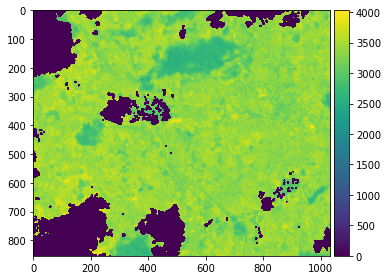

In [89]:
skio.imshow(flood_fill(shadow_inds[42], (600,150), 1))

In [108]:
def flood_fill_shadow(potential_shadow_index, potential_shadow_mask, seed, label_val, dn_max):
    potential_shadow_index = np.where(potential_shadow_mask != label_val,dn_max,potential_shadow_index)
    return flood_fill(potential_shadow_index, seed, 1, tolerance=500)
testf = flood_fill_shadow(shadow_inds[42], potential_shadow_masks[42], (150, 600), 0, configs.dn_max)

In [95]:
potential_shadow_index = np.where(potential_shadow_masks[42] != 0,configs.dn_max, shadow_inds[42])

In [101]:
testf[600,150]

1.0

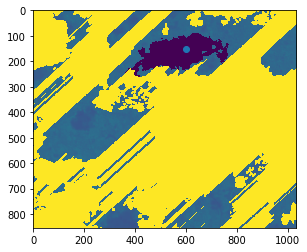

In [109]:
plt.imshow(testf)
plt.scatter([600], [150])

/home/rave/miniconda3/envs/geo/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:78: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


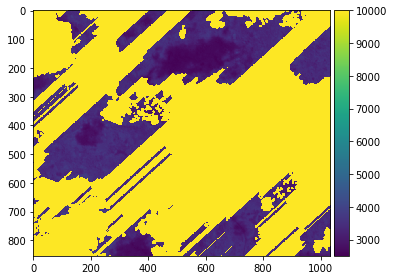

In [96]:
skio.imshow(potential_shadow_index)

In [146]:
r, c = M.shape

In [153]:
grid_x, grid_y = np.mgrid[0:r, 0:c]

In [160]:
points = np.argwhere(potential_shadow_masks[10]==1)
values = M[potential_shadow_masks[10]==1]

In [164]:
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

In [180]:
state['ind_l_good'].shape

(362,)

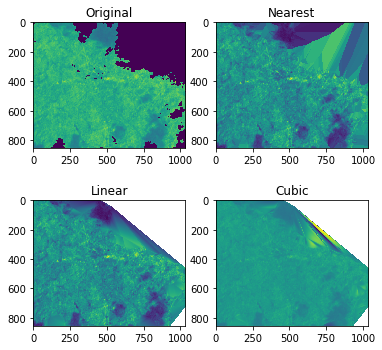

In [169]:
import matplotlib.pyplot as plt
plt.subplot(221)
plt.imshow(M)
plt.title('Original')
plt.subplot(222)
plt.imshow(grid_z0)
plt.title('Nearest')
plt.subplot(223)
plt.imshow(grid_z1)
plt.title('Linear')
plt.subplot(224)
plt.imshow(grid_z2)
plt.title('Cubic')
plt.gcf().set_size_inches(6, 6)
plt.show()

In [163]:
from scipy.interpolate import griddata

In [ ]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in np.arange(51):
        plt.figure()
        x = state['shadow_new'][i,:,:].copy()
        plt.title("idl shadow index " + str(i))
        skio.imshow(x)
        plt.figure()
        plt.title("python masks " + str(i))
        skio.imshow(shadow_inds[i,:,:])

In [ ]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in np.arange(51):
        plt.figure()
        x = state['mask2'][i,:,:].copy()
        x[x==99] = 1
        plt.title("idl masks " + str(list(np.unique(x))))
        skio.imshow(x)
        plt.figure()
        plt.title(str(i)+"python masks " + str(list(np.unique(potential_shadow_masks[i,:,:]))))
        skio.imshow(potential_shadow_masks[i,:,:])
        plt.figure()
        plt.title("struct")
        skio.imshow(structs[i])

# Checking why kmeans centers are not super similar, probably due to the initialization method

In [ ]:
masks, cluster_centers = sample_and_kmeans(hot_t_series, hard_hot=6000, sample_size=10000)

cluster_centers

In [ ]:
state['center_class']

In [ ]:
refined_masks.shape

In [ ]:
for i in np.arange(51):
    plt.figure()
    skio.imshow(initial_kmeans_clouds[i,:,:])
    plt.figure()
    skio.imshow(configs.t_series[:,:,0,i])
    plt.figure()
    plt.title("idl refined masks")
    skio.imshow(state['kmeans_masks'][i])
    plt.figure()
    plt.title("refined masks")
    skio.imshow(refined_masks[i,:,:])

In [ ]:
skio.imshow(initial_kmeans_clouds_binary[32,:,:])

In [ ]:
skio.imshow(state['kmeans_masks'][32])

In [ ]:
state['g_th']

In [ ]:
cloud_series_mean_global = np.nanmean(hot_potential_cloudy.flatten(), axis=0)
cloud_series_std_global = np.nanstd(hot_potential_cloudy.flatten(), axis=0)
global_cloud_thresh = cloud_series_mean_global - 1.0*cloud_series_std_global
global_cloud_thresh

large difference between hot image occurs for some images without clouds. error should lie between 77 and 97 lines in atsa.pro because the bin calculation is the same, intercepts and slopes are the same.

In [ ]:
skio.imshow(hot_t_series[0,:,:])

In [ ]:
np.allclose(state['HOT'][0,:,:], hot_t_series[0,:,:], atol=.01, rtol=1)

In [ ]:
skio.imshow(refined_masks[1,:,:])

# notes on IDL code follow the values to determine what conditions to use in python

The mask values are as follows (everything starts as 1) and water mask is 0 value where water

* 3 - background/SLC errors, missing data
* 2 - cloud (see lines 365 through 378)
* 1 - clear land (see lines 323 through 331, where idl returns 1 or 0 from ge condition)
* 0 - shadow
* 99 - shadow edge, removed because it produces artifacts in Planet imagery

# Making presentation figures

In [ ]:
def keep_imgs_with_meta(img_paths, meta_paths, DIR):
    imgs_with_meta = []
    for im in list(map(os.path.basename, sorted(img_paths))):
        for meta in list(map(os.path.basename, sorted(meta_paths))):
            if meta[0:15] == im[0:15]:
                imgs_with_meta.append(im)
    return [os.path.join(DIR,name) for name in imgs_with_meta]

In [ ]:
udm_pattern = "/home/rave/cloud-free-planet/notebooks/jan-september/*udm*.tif"
udm_paths = glob.glob(udm_pattern)
udm_paths = sorted(udm_paths)
meta_pattern = "/home/rave/cloud-free-planet/notebooks/jan-september/*metadata.json"
meta_paths = glob.glob(meta_pattern)
meta_paths = sorted(meta_paths)

In [ ]:
udm_with_meta = keep_imgs_with_meta(udm_paths, meta_paths, "/home/rave/cloud-free-planet/notebooks/jan-september/")

In [ ]:
arrs = [ski.io.imread(path) for path in udm_with_meta]
udms_stacked = reshape_as_raster(np.dstack(arrs))

In [ ]:
udms_stacked.shape

In [ ]:
import matplotlib.pyplot as plt
i = 0
while i<20:
    plt.figure(figsize=(10,10))
    plt.title("HOT Index Mask (Partial ATSA)")
#     plt.title("Intercept:"+str(intercepts_slopes[i][0])+
#               " and Slope:"+str(intercepts_slopes[i][1]))
    ski.io.imshow(cloud_masks[i,:,:])
    plt.savefig(str(i)+"atsa-k.png")
    plt.figure(figsize=(10,10))
    plt.title("UDM Mask (Planet)")
    ski.io.imshow(udms_stacked[i,:,:])
    plt.savefig(str(i)+"udm.png")
#     ski.io.imshow(hot_t_series[i,:,:])
    
    plt.figure(figsize=(10,10))
    plt.title("True Color")
    ski.io.imshow(reorder_to_rgb(t_series[:,:,:,i]))
    plt.savefig(str(i)+"true-color.png")
    
    i+=1



Testing Dilation

In [ ]:
import numpy as np
from skimage.draw import rectangle, line
from skimage.morphology import dilation
import matplotlib.pyplot as plt
import skimage.io as skio

img = np.zeros((100, 100), dtype=np.uint8)
start = (50, 50)
extent = (10, 10)
rr, cc = rectangle(start, extent=extent, shape=img.shape)
img[rr, cc] = 1
plt.figure()
plt.title("fake square cloud")
skio.imshow(img)

test = [[31,33],[31,-33],[-31,-33],[-31,33]]
for t in test:
    plt.figure()
    plt.title("fake square shadow struct for a particular direction")
    skio.imshow(make_rectangular_struct(t))
    plt.figure()
    skio.imshow(dilation(img, selem=make_rectangular_struct(t)))